# **MOUNT THE DRIVE**

In [1]:
import os
from google.colab import drive

# 1. Unmount the drive if it's already mounted (optional, but good practice)
# if os.path.isdir('/content/drive'):
#     drive.flush_and_unmount()

# 2. Forcibly remove the existing directory (this is the key fix)
# The '-rf' flag means recursively (r) and forcibly (f) delete the directory and its contents.
# !rm -rf /content/drive

# 3. Remount the drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive



--- Initializing VLM Models (BLIP & CLIP)... ---


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✅ VLM models loaded successfully.

--- STEP 0: FILE PATH VERIFICATION ---
All necessary files found. Proceeding with FULL AnoGAN pipeline...
----------------------------------------------------

✅ DCGAN Generator loaded successfully.
✅ DCGAN Discriminator loaded successfully.

--- STEP 2: INFERENCE (FULL AnoGAN INVERSION) ON A SINGLE IMAGE ---
Starting full AnoGAN inversion for 5000 steps...
  Step 1000/5000, Total Loss: 0.130648, Recon Loss: 0.102083
  Step 2000/5000, Total Loss: 0.105961, Recon Loss: 0.080963
  Step 3000/5000, Total Loss: 0.078593, Recon Loss: 0.055833
  Step 4000/5000, Total Loss: 0.071191, Recon Loss: 0.049068
  Step 5000/5000, Total Loss: 0.070299, Recon Loss: 0.048186
Inversion complete.
Model: AnoGAN+VLM -> Prediction: NORMAL | Composite Anomaly Score: 0.317508
Metrics: L_Recon=0.0482 | L_Feature=0.2693 | SSIM=0.4814 | PSNR=19.19 dB | Semantic Sim=0.6652
--- CAUSAL EXPLANATION OF THE RESULT ---
The AnoGAN system analyzes the image based on three key factors:

1.

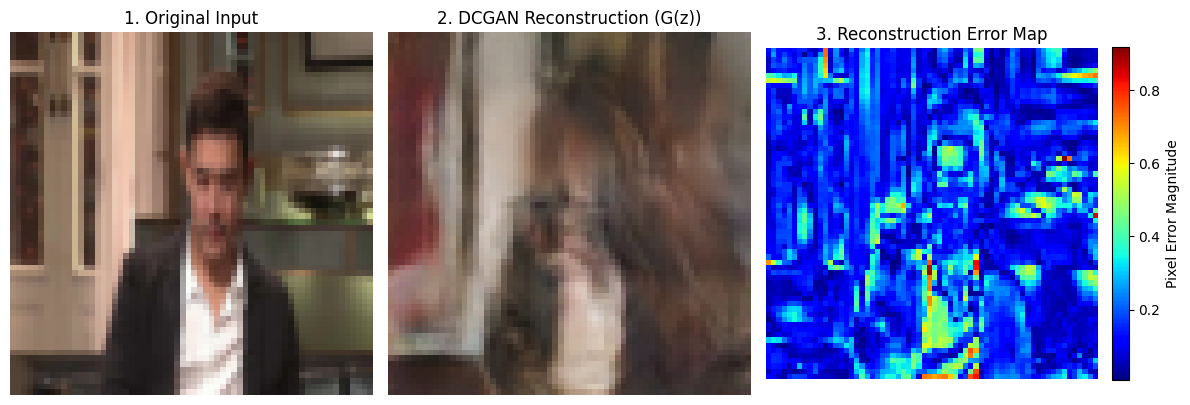


--- STEP 4: LATENT TRAVERSAL (Visualizing the Latent Space) ---
Traversing Latent Dimension: 81 (Range: -3.0 to 3.0)


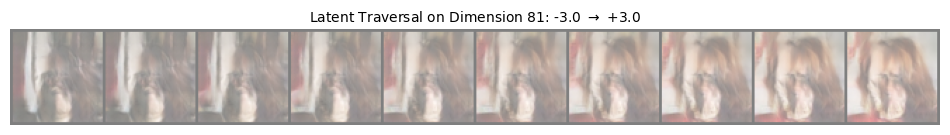

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.utils as vutils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sys
from skimage.metrics import structural_similarity as ssim
import math

# --- 0. Configuration & Paths ---
IMAGE_SIZE = 64
CHANNELS = 3
LATENT_DIM_DCGAN = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONCEPTUAL_THRESHOLD = 1.0 # AnoGAN Anomaly Threshold

# --- DCGAN Parameters ---
DCGAN_PARAMS = {
    'nz': LATENT_DIM_DCGAN,
    'ngf': 64, # Generator feature depth
    'ndf': 64, # Discriminator feature depth
    'nc': CHANNELS,
}

# --- Paths ---
# CRITICAL STEP: Please update the 'drive_path'
drive_path = "/content/drive/MyDrive/celeba_models/"

# Path to the DCGAN Generator Checkpoint (assumed to be inside a dictionary structure)
DCGAN_MODEL_PATH = drive_path + "model_final.pth"
# Path to the image you want to test
INPUT_IMAGE_PATH = drive_path + "frame_0006.jpg"

# --- Hyperparameters for Latent Vector Inversion (AnoGAN) ---
INVERSION_STEPS = 5000
INVERSION_LR = 0.005
ALPHA_RECONSTRUCTION = 0.90 # Weighting for the L_recon loss

# --- VLM Components Placeholder (Initialized later) ---
VLM_AVAILABLE = False
blip_processor, blip_model = None, None
clip_model, clip_preprocess = None, None

# --- Set Seeds for Reproducibility ---
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# ====================================================================
# VLM INTEGRATION FUNCTIONS
# ====================================================================
def _init_vlm_models():
    """Initializes VLM models and returns success status."""
    global blip_processor, blip_model, clip_model, clip_preprocess, VLM_AVAILABLE
    try:
        print("\n--- Initializing VLM Models (BLIP & CLIP)... ---")
        from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPProcessor, CLIPModel

        # BLIP
        blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(DEVICE)

        # CLIP
        clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
        clip_preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

        VLM_AVAILABLE = True
        print("✅ VLM models loaded successfully.")
        return True
    except ImportError:
        print("❌ VLM initialization failed: 'transformers' library not found. VLM analysis disabled.")
    except Exception as e:
        print(f"❌ VLM initialization failed: {e}. VLM analysis disabled.")
    VLM_AVAILABLE = False
    return False

def get_image_description_and_reason(img_pil):
    """Runs BLIP for caption and CLIP for classification reason on a PIL image."""
    global blip_processor, blip_model, clip_preprocess, clip_model
    if not VLM_AVAILABLE:
        return "N/A (VLM Disabled)", "N/A (VLM Disabled)"

    try:
        # 1. BLIP Caption Generation
        inputs = blip_processor(images=img_pil, return_tensors="pt").to(DEVICE)
        caption_ids = blip_model.generate(**inputs, max_new_tokens=40)
        description = blip_processor.batch_decode(caption_ids, skip_special_tokens=True)[0]

        # 2. CLIP-based Reasoning (User's prompts adapted)
        text_prompts = [
            "a real human face photo",
            "a fake or AI-generated face",
            "skin artifacts",
            "lighting unnatural",
            "blurry face boundary",
            "asymmetric eyes"
        ]
        tokens = clip_preprocess(text=text_prompts, images=img_pil, return_tensors="pt", padding=True).to(DEVICE)
        with torch.no_grad():
            outputs = clip_model(**tokens)
            probs = outputs.logits_per_image.softmax(dim=1)

        best_reason = text_prompts[probs.argmax()]

        return description, best_reason

    except Exception as e:
        print(f"VLM inference error: {e}")
        return "VLM Error", "VLM Error"

def calculate_clip_similarity(caption1, caption2):
    """Calculates cosine similarity between text embeddings of two captions."""
    global clip_model, clip_preprocess
    if not VLM_AVAILABLE:
        return 0.0

    try:
        text_inputs = clip_preprocess(text=[caption1, caption2], return_tensors="pt", padding=True).to(DEVICE)
        with torch.no_grad():
            text_features = clip_model.get_text_features(**text_inputs)
        # Cosine similarity
        similarity = torch.nn.functional.cosine_similarity(text_features[0].unsqueeze(0), text_features[1].unsqueeze(0))
        return similarity.item()
    except Exception as e:
        print(f"CLIP Similarity error: {e}")
        return 0.0

# ====================================================================
# HELPER FUNCTIONS & METRICS
# (Remaining helper functions are unchanged)
# ====================================================================

def check_file_existence(file_path, file_description):
    """Checks if a critical file exists and exits if it doesn't."""
    if not os.path.exists(file_path):
        print("="*80)
        print(f"❌ CRITICAL ERROR: {file_description} file NOT FOUND.")
        print(f"Expected Path: {file_path}")
        print("ACTION REQUIRED: Check if your Google Drive is mounted and the 'drive_path' variable is correct.")
        print("="*80)
        sys.exit(1)

def calculate_psnr(img1, img2):
    """Calculates PSNR in dB between two images (numpy arrays, 0-1 range)."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return 100
    max_i = 1.0
    psnr = 20 * math.log10(max_i / math.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2):
    """Calculates SSIM between two images (numpy arrays, 0-1 range)."""
    ssim_val = ssim(img1, img2, data_range=1.0, channel_axis=2)
    return ssim_val

def denormalize_and_tensor_to_numpy(tensor):
    """Denormalizes a single 3xHxW tensor from [-1, 1] to [0, 1] range for visualization."""
    denormalized_tensor = (tensor * 0.5) + 0.5

    if denormalized_tensor.ndim == 3 and denormalized_tensor.shape[0] == CHANNELS:
        return np.transpose(denormalized_tensor.cpu().numpy(), (1, 2, 0))
    else:
        # For batched output (grid)
        img_grid = vutils.make_grid(denormalized_tensor.cpu(), nrow=8, padding=0, normalize=True)
        return np.transpose(img_grid.numpy(), (1, 2, 0))

def tensor_to_pil(tensor):
    """Converts a single 3xHxW tensor (normalized -1 to 1) back to PIL Image (0-255)."""
    # Denormalize to 0-1
    denormalized_tensor = (tensor.cpu() * 0.5) + 0.5
    # Scale to 0-255 and convert to numpy
    np_img = (denormalized_tensor.squeeze(0).mul(255).add(0.5).clamp(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy())
    return Image.fromarray(np_img)


# ====================================================================
# MODEL DEFINITIONS (DCGAN Generator and Discriminator)
# (Unchanged from user's provided code)
# ====================================================================

class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        ngf = params['ngf']
        nz = params['nz']
        nc = params['nc']
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False), nn.BatchNorm2d(ngf * 8), nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False), nn.BatchNorm2d(ngf * 4), nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False), nn.BatchNorm2d(ngf * 2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False), nn.BatchNorm2d(ngf), nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False), nn.Tanh()
        )
    def forward(self, x): return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()
        ndf = params['ndf']
        nc = params['nc']
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf * 2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf * 4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf * 8), nn.LeakyReLU(0.2, inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )
    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output.view(-1, 1), features

# --- MAPPING DICTIONARIES ---
G_KEY_MAPPING = {
    "tconv1.weight": "net.0.weight", "bn1.weight": "net.1.weight", "bn1.bias": "net.1.bias", "bn1.running_mean": "net.1.running_mean", "bn1.running_var": "net.1.running_var",
    "tconv2.weight": "net.3.weight", "bn2.weight": "net.4.weight", "bn2.bias": "net.4.bias", "bn2.running_mean": "net.4.running_mean", "bn2.running_var": "net.4.running_var",
    "tconv3.weight": "net.6.weight", "bn3.weight": "net.7.weight", "bn3.bias": "net.7.bias", "bn3.running_mean": "net.7.running_mean", "bn3.running_var": "net.7.running_var",
    "tconv4.weight": "net.9.weight", "bn4.weight": "net.10.weight", "bn4.bias": "net.10.bias", "bn4.running_mean": "net.10.running_mean", "bn4.running_var": "net.10.running_var",
    "tconv5.weight": "net.12.weight"
}

D_KEY_MAPPING = {
    "conv1.weight": "feature_extractor.0.weight",
    "conv2.weight": "feature_extractor.2.weight", "bn2.weight": "feature_extractor.3.weight", "bn2.bias": "feature_extractor.3.bias", "bn2.running_mean": "feature_extractor.3.running_mean", "bn2.running_var": "feature_extractor.3.running_var",
    "conv3.weight": "feature_extractor.5.weight", "bn3.weight": "feature_extractor.6.weight", "bn3.bias": "feature_extractor.6.bias", "bn3.running_mean": "feature_extractor.6.running_mean", "bn3.running_var": "feature_extractor.6.running_var",
    "conv4.weight": "feature_extractor.8.weight", "bn4.weight": "feature_extractor.9.weight", "bn4.bias": "feature_extractor.9.bias", "bn4.running_mean": "feature_extractor.9.running_mean", "bn4.running_var": "feature_extractor.9.running_var",
    "conv5.weight": "classifier.0.weight"
}

# ====================================================================
# LOADING UTILITIES (Unchanged)
# ====================================================================

def load_gan_component(net, dcgan_path, key_mapping, component_name):
    """Loads a GAN component (G or D) using the remapping logic."""
    try:
        checkpoint = torch.load(dcgan_path, map_location=DEVICE)
        extract_key = component_name.lower()
        if extract_key not in checkpoint:
            print(f"Key '{extract_key}' not found in checkpoint. Skipping load for {component_name}.")
            return False

        raw_state_dict = checkpoint[extract_key]
        new_state_dict = {}

        for old_key, tensor in raw_state_dict.items():
            if old_key in key_mapping:
                new_state_dict[key_mapping[old_key]] = tensor

        for old_key, tensor in raw_state_dict.items():
            if 'num_batches_tracked' in old_key:
                 for map_key, new_key in key_mapping.items():
                     if map_key in old_key and 'bn' in map_key and 'running' in new_key:
                         index_part = new_key.split('.')
                         tracked_key = f"{index_part[0]}.{index_part[1]}.num_batches_tracked"
                         new_state_dict[tracked_key] = tensor
                         break

        net.load_state_dict(new_state_dict, strict=False)
        print(f"✅ DCGAN {component_name} loaded successfully.")
        return True
    except Exception as e:
        print("="*80)
        print(f"❌ DCGAN {component_name} Loading Failed: {e}")
        print("ACTION REQUIRED: Verify DCGAN_MODEL_PATH and the checkpoint structure.")
        print("="*80)
        return False

# ====================================================================
# INFERENCE CORE: LATENT INVERSION (Full AnoGAN Loss)
# (Unchanged)
# ====================================================================

def invert_latent_vector_anogan(netG, netD, X_target):
    """
    Finds the latent vector z using a composite loss:
    Loss = alpha * L_recon + (1-alpha) * L_feature
    """
    netG.eval()
    netD.eval()
    z = torch.randn(1, LATENT_DIM_DCGAN, 1, 1, device=DEVICE).requires_grad_()
    optimizer = optim.Adam([z], lr=INVERSION_LR)

    with torch.no_grad():
        _, f_target = netD(X_target)

    print(f"Starting full AnoGAN inversion for {INVERSION_STEPS} steps...")

    for i in range(1, INVERSION_STEPS + 1):
        optimizer.zero_grad()
        X_reconstructed = netG(z)
        _, f_reconstructed = netD(X_reconstructed)

        # --- 1. Reconstruction Loss (L_recon) ---
        l_recon = torch.mean((X_reconstructed - X_target) ** 2)

        # --- 2. Feature Matching Loss (L_feature) ---
        l_feature = torch.mean((f_reconstructed - f_target) ** 2)

        # --- 3. Combined Loss ---
        total_loss = ALPHA_RECONSTRUCTION * l_recon + (1 - ALPHA_RECONSTRUCTION) * l_feature

        total_loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            print(f"  Step {i}/{INVERSION_STEPS}, Total Loss: {total_loss.item():.6f}, Recon Loss: {l_recon.item():.6f}")

    print("Inversion complete.")
    anomaly_score = l_recon.item() + l_feature.item()

    return X_reconstructed.detach(), z.detach(), l_recon.item(), l_feature.item(), anomaly_score

def latent_traversal(netG, z_optimal, num_steps=10):
    """
    Performs a traversal along a randomly selected dimension
    in the latent space around the optimal z.
    """
    print("\n--- STEP 4: LATENT TRAVERSAL (Visualizing the Latent Space) ---")
    netG.eval()
    dim_to_vary = random.randint(0, LATENT_DIM_DCGAN - 1)
    traversal_range = torch.linspace(-3.0, 3.0, num_steps, device=DEVICE)

    print(f"Traversing Latent Dimension: {dim_to_vary} (Range: -3.0 to 3.0)")

    traversed_images = []
    for step in traversal_range:
        z_traversed = z_optimal.clone()
        z_traversed[0, dim_to_vary, 0, 0] = step
        with torch.no_grad():
            img = netG(z_traversed)
            traversed_images.append(img.squeeze(0))

    traversal_grid = vutils.make_grid(torch.stack(traversed_images), nrow=num_steps, padding=2, normalize=True)
    traversal_np = denormalize_and_tensor_to_numpy(traversal_grid)

    plt.figure(figsize=(12, 1.5))
    plt.imshow(traversal_np)
    plt.title(f"Latent Traversal on Dimension {dim_to_vary}: -3.0 $\\rightarrow$ +3.0", fontsize=10)
    plt.axis('off')
    plt.show()

# ====================================================================
# VLM REPORT GENERATION (UPDATED)
# ====================================================================

def format_final_report(metrics, vlm_data):
    """Formats the final output string to match the user's requested VLM+MLP format."""

    report_text = f"""
================================================================================
Model: AnoGAN+VLM -> Prediction: {vlm_data['status']} | Composite Anomaly Score: {metrics['anomaly_score']:.6f}
Metrics: L_Recon={metrics['l_recon']:.4f} | L_Feature={metrics['l_feature']:.4f} | SSIM={metrics['ssim_val']:.4f} | PSNR={metrics['psnr_val']:.2f} dB | Semantic Sim={vlm_data['semantic_similarity']:.4f}
--- CAUSAL EXPLANATION OF THE RESULT ---
The AnoGAN system analyzes the image based on three key factors:

1. Pixel-Level Reconstruction Quality (L_Recon/SSIM/PSNR):
 - **L_Reconstruction ({metrics['l_recon']:.4f})**, **SSIM ({metrics['ssim_val']:.4f})**, and **PSNR ({metrics['psnr_val']:.2f})** measure the basic pixel difference.

2. Feature Matching Judgment (AnoGAN Core):
 - The **Composite Anomaly Score ({metrics['anomaly_score']:.6f})** is driven by **L_Feature ({metrics['l_feature']:.4f})**, which assesses if the image's internal features are typical of the training distribution.

3. Semantic Consistency (BLIP/CLIP Check):
 - **Original Caption (BLIP):** "{vlm_data['caption_orig']}"
 - **Original VLM Reason (CLIP):** The original image is most similar to **'{vlm_data['reason_orig']}'**.
 - **Reconstructed Caption (BLIP):** "{vlm_data['caption_recon']}"
 - **Reconstructed VLM Reason (CLIP):** The reconstructed image is most similar to **'{vlm_data['reason_recon']}'**.
 - **Semantic Similarity (CLIP):** {vlm_data['semantic_similarity']:.4f}

 - **VLM Conclusion:**
   - If Semantic Similarity is low, the core meaning changed drastically after reconstruction, indicating the sample is **OUT-OF-DISTRIBUTION**.
   - If Semantic Similarity is high, the model preserved the key features, reinforcing the AnoGAN score.
==========================================================
"""
    return report_text.strip()


# ====================================================================
# MAIN PREDICTION FUNCTION (UPDATED)
# ====================================================================

def predict_anomaly(image_path, netG, netD):

    # 1. Load and Preprocess Image
    try:
        img_pil_orig = Image.open(image_path).convert('RGB')
        X_original = transform(img_pil_orig).unsqueeze(0).to(DEVICE)
    except FileNotFoundError:
        print(f"❌ Error: Input image not found at {image_path}")
        return
    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")
        return

    # 2. STAGE 1: DCGAN INVERSION (Reconstruction)
    X_reconstructed, z_optimal, l_recon, l_feature, anomaly_score = invert_latent_vector_anogan(netG, netD, X_original)

    # Convert reconstructed tensor back to PIL for VLM analysis
    img_pil_recon = tensor_to_pil(X_reconstructed)

    # Calculate error map (Pixel error is used for visualization)
    E_map = torch.abs(X_original - X_reconstructed)

    # --- METRIC CALCULATION ---
    mse_val = torch.mean((X_original - X_reconstructed) ** 2).item()
    X_orig_np = denormalize_and_tensor_to_numpy(X_original.squeeze(0))
    X_recon_np = denormalize_and_tensor_to_numpy(X_reconstructed.squeeze(0))
    psnr_val = calculate_psnr(X_orig_np, X_recon_np)
    ssim_val = calculate_ssim(X_orig_np, X_recon_np)

    # 3. VLM Analysis on Original and Reconstructed Images
    caption_orig, reason_orig = get_image_description_and_reason(img_pil_orig)
    caption_recon, reason_recon = get_image_description_and_reason(img_pil_recon)

    # Calculate Semantic Similarity between captions
    semantic_similarity = calculate_clip_similarity(caption_orig, caption_recon)

    # 4. Report Generation
    is_anomaly = anomaly_score > CONCEPTUAL_THRESHOLD
    final_status = "ANOMALY (Score > 1.0)" if is_anomaly else "NORMAL"

    metrics = {
        'anomaly_score': anomaly_score,
        'l_recon': l_recon,
        'l_feature': l_feature,
        'mse_val': mse_val,
        'psnr_val': psnr_val,
        'ssim_val': ssim_val,
    }

    vlm_data = {
        'status': final_status,
        'caption_orig': caption_orig,
        'reason_orig': reason_orig,
        'caption_recon': caption_recon,
        'reason_recon': reason_recon,
        'semantic_similarity': semantic_similarity,
    }

    # Print the formatted report
    print(format_final_report(metrics, vlm_data))

    # 5. VISUALIZATIONS
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(X_orig_np)
    axes[0].set_title("1. Original Input")
    axes[0].axis('off')

    axes[1].imshow(X_recon_np)
    axes[1].set_title("2. DCGAN Reconstruction (G(z))")
    axes[1].axis('off')

    error_np = E_map.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    grayscale_error = error_np.mean(axis=2)

    im = axes[2].imshow(grayscale_error, cmap='jet')
    fig.colorbar(im, ax=axes[2], label='Pixel Error Magnitude', fraction=0.046, pad=0.04)
    axes[2].set_title("3. Reconstruction Error Map")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show() # Display the plots together

    # 6. LATENT TRAVERSAL
    latent_traversal(netG, z_optimal)


# ====================================================================
# EXECUTION
# ====================================================================
if __name__ == '__main__':

    # Initialize VLM models first (if possible)
    _init_vlm_models()

    print("\n--- STEP 0: FILE PATH VERIFICATION ---")

    check_file_existence(DCGAN_MODEL_PATH, "DCGAN Generator/Discriminator Checkpoint")
    check_file_existence(INPUT_IMAGE_PATH, "Input Image")

    print("All necessary files found. Proceeding with FULL AnoGAN pipeline...")
    print("----------------------------------------------------\n")

    # --- STEP 1: INITIALIZE AND LOAD GAN COMPONENTS ---
    netG = Generator(DCGAN_PARAMS).to(DEVICE)
    netD = Discriminator(DCGAN_PARAMS).to(DEVICE)

    # Load Generator (G)
    load_gan_component(netG, DCGAN_MODEL_PATH, G_KEY_MAPPING, "Generator")
    # Load Discriminator (D)
    load_gan_component(netD, DCGAN_MODEL_PATH, D_KEY_MAPPING, "Discriminator")

    print("\n--- STEP 2: INFERENCE (FULL AnoGAN INVERSION) ON A SINGLE IMAGE ---")

    # Preprocessing
    transform = T.Compose([
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    predict_anomaly(INPUT_IMAGE_PATH, netG, netD)
